## This is my attempt to use martin's data creation technique and then put it in Siamene Network using Fast AI. I am using following links for this:
https://www.kaggle.com/martinpiotte/whale-recognition-model-with-score-0-78563/output
https://github.com/radekosmulski/whale/blob/master/siamese_network_prototype.ipynb

In [1]:
# Suppress annoying stderr output when importing keras.
import sys
import platform
old_stderr = sys.stderr
sys.stderr = open('/dev/null' if platform.system() != 'Windows' else 'nul', 'w')

sys.stderr = old_stderr

import random
from scipy.ndimage import affine_transform

import pickle
import numpy as np
from math import sqrt

# Determise the size of each image
from os.path import isfile
from PIL import Image as pil_image
from tqdm import tqdm_notebook

from pandas import read_csv
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/train.csv')
im_count = df[df.Id != 'new_whale'].Id.value_counts()
im_count.name = 'sighting_count'
df = df.join(im_count, on='Id')

For training data, we are taking all the images except for the category - New Whale

In [3]:
new_df = df[df['Id']!= 'new_whale']
new_df = new_df[new_df['sighting_count']>1]

print('shape of data for training ',new_df.shape)
new_df.drop(columns = ['sighting_count'] , inplace=True)
new_df.head(2)

shape of data for training  (13624, 3)


,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a


In [4]:
new_df.reset_index(inplace=True)
new_df.drop(columns='index' , inplace=True)
new_df.tail(3)

,Image,Id
13621,ffef89eed.jpg,w_9c506f6
13622,fff7faf61.jpg,w_9cf0388
13623,fff9002e0.jpg,w_bd1c3d5


In [5]:
"""
The data set we are using for training contains all images except of new whales.
we don't require creating phase values for this  datasets , as duplicate images are very few.
i am using index present in train.csv as the phase value as we can use it for indexing very easily 
"""

tagged = dict([(p,w) for _,p,w in new_df.to_records()])
h2ps = dict([(idx , p ) for   idx,p,w in new_df.to_records()])
p2h   = dict([(p , idx) for idx , p , w in new_df.to_records()])
h2p = h2ps.copy()
join = tagged.copy()

In [6]:
#def expand_path(p):
#    if isfile('data/train-224/' + p): return 'data/train-224/' + p
#    if isfile('data/test-224/' + p): return 'data/test-224/' + p
#    return p
#
#p2size = {}
#for p in tqdm_notebook(join):
#    size      = pil_image.open(expand_path(p)).size
#    p2size[p] = size
#len(p2size), list(p2size.items())[:5]

In [7]:
## phase value for all categories except new whale
h2ws = {}
new_whale = 'new_whale'
for p,w in tagged.items():
    if w != new_whale: # Use only identified whales
        h = p2h[p]
        if h not in h2ws: h2ws[h] = []
        if w not in h2ws[h]: h2ws[h].append(w)
for h,ws in h2ws.items():
    if len(ws) > 1:
        h2ws[h] = sorted(ws)
len(h2ws)

13624

In [8]:
## for each whale category, observe the associated phase values , 
##store all whale categories even the categories with just one image ( this is  different from martin's approach)

w2hs = {}
val_fns = []

for h,ws in h2ws.items():
    if len(ws) == 1: # Use only unambiguous pictures
        w = ws[0]
        if w not in w2hs: w2hs[w] = []
        if h not in w2hs[w]: w2hs[w].append(h)
            
for w,hs in w2hs.items():
    if len(hs) >= 1:
        w2hs[w] = sorted(hs)
    else:
        val_fns.append(df.Image[df.Id == w].tolist()[0])
len(w2hs), len(val_fns)

(2931, 0)

In [9]:
def read_raw_image(p):
    img = pil_image.open(expand_path(p))
    return img

In [10]:
train = [] # A list of  indices of images to be used in training data.
for hs in w2hs.values():
    if len(hs) >= 1:
        train += hs
random.shuffle(train)
train_set = set(train)

In [11]:
len(train_set)

13624

In [12]:
## we have whales categories with phases(images) more than 1. shuffle the phase values now.
w2ts = {} #Associate the image index from train to each whale id.
for w,hs in w2hs.items():
    for h in hs:
        if h in train_set:
            if w not in w2ts: w2ts[w] = []
            if h not in w2ts[w]: w2ts[w].append(h)
for w,ts in w2ts.items(): w2ts[w] = np.array(ts)
## then again for each whale categories see how many images you have , 
## you are working with 5004 whale categories and 15697 images 
    
    
t2i = {} # The position in train of each training image id
for i,t in enumerate(train): t2i[t] = i

len(train),len(w2ts)

(13624, 2931)

In [13]:
# from keras.utils import Sequence
# import keras

from IPython.core.debugger import set_trace
import random
#from keras import backend as K

try:
    from lap import lapjv
    segment = False
except ImportError:
    print('Module lap not found, emulating with much slower scipy.optimize.linear_sum_assignment')
    segment = True
    from scipy.optimize import linear_sum_assignment


Import functions from fast ai library

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy_thresh
from fastai.basic_data import *
from torch.utils.data import DataLoader, Dataset
from torch import nn
from fastai.callbacks.hooks import num_features_model, model_sizes
from fastai.layers import BCEWithLogitsFlat
from fastai.basic_train import Learner
from skimage.util import montage
import pandas as pd
from torch import optim
import re

from utils import *

from IPython.core.debugger import set_trace
from functional import seq


In [15]:
name = f'resnet34_martin'

fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}  
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)

In [16]:
def path2valid(path):
    #print(path.split('/')[-1])
    return True if path.split('/')[-1] in val_fns else False

In [17]:
SZ = 224
BS = 64
NUM_WORKERS = 8
SEED=0

Creating dataset for all the training images. Because of some reason , i am not able to create validation set as well ( produces error while indexing from match and unmatch matrices. If someone is able to find the work arounf the help will be appreciated

In [18]:
classes = df.Id.unique()
data = (
    ImageItemList  ##df[(df.Id != 'new_whale') & (df.sighting_count >1)]
        .from_df(df[(df.Id != 'new_whale') & (df.sighting_count > 1)], f'data/train-{SZ}', cols=['Image'])
        .no_split()
        #.split_by_valid_func(lambda path: path2valid(path)) 
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageItemList.from_folder(f'data/test-{SZ}'))
        .transform(get_transforms(max_lighting=0.3, max_zoom=1., do_flip=False), 
                   size=SZ, resize_method=ResizeMethod.SQUISH))

In [19]:
print(len(train))
print(len(data.train.x))
print(len(data.valid.x))

13624
15697
1


TwoImDataset creation is the part where I am trying to replicate 'TrainingData Class' from https://www.kaggle.com/martinpiotte/whale-recognition-model-with-score-0-78563/output
For whale categories having just one images in training data , matching pair -  same image pair (A,A) . For other categories it creates a de arrangement.  

In [20]:
def is_even(num): return num % 2 == 0

class TwoImDataset(Dataset):
    def __init__(self, ds ,score  , steps = 1000):
        self.ds = ds
        self.whale_ids = ds.y.items
        self.steps =1000
        self.score  = -score
        for ts in w2ts.values():
            idxs =  ts.copy() #[t2i[t] for t in ts]
            #idxs = [i for i in  idxs if i <score.shape[0]]
            for i in idxs:
                for j in idxs:
                    self.score[i,j] = 10000.0   # Set a large value for matching
        
        self.on_epoch_end()
        
    def __len__(self):
        return 2 * len(self.ds)
    def __getitem__(self, idx):
        if is_even(idx):
            return self.sample_image(idx // 2 , 1)
        else: return self.sample_image((idx-1) // 2 ,0)        

    def sample_image(self, idx , tag):
        #set_trace()
        if tag==0:
            first_image_id =  self.match[idx][0]
            second_image_id = self.match[idx][1]
            #if first_image_id < len(self.ds) and second_image_id< len(self.ds):         
            return self.construct_example(self.ds[first_image_id][0], self.ds[second_image_id][0], 1)
        else:
            first_image_id =  self.unmatch[idx][0]
            second_image_id = self.unmatch[idx][1]     
            return self.construct_example(self.ds[first_image_id][0], self.ds[second_image_id][0], 0)
  
    def on_epoch_end(self):
        if self.steps <= 0: return # Skip this on the last epoch.
        self.steps     -= 1
        self.match      = []
        self.unmatch    = []
        if segment:
            tmp   = []
            batch = 512
            for start in range(0, score.shape[0], batch):
                end = min(score.shape[0], start + batch)
                _, x = linear_sum_assignment(self.score[start:end, start:end])
                tmp.append(x + start)
            x = np.concatenate(tmp)
        else:
            _,_,x = lapjv(self.score) # Solve the linear assignment problem
        y = np.arange(len(x),dtype=np.int32)

        # Compute a derangement for matching whales
        for ts in w2ts.values():
            d = ts.copy()
            if (len(d)==1):
                for ab in zip(ts,d): self.match.append(ab)
            else:                
                while True:
                    random.shuffle(d)
                    if not np.any(ts == d): break
                for ab in zip(ts,d): self.match.append(ab)

        # Construct unmatched whale pairs from the LAP solution.
        for i,j in zip(x,y):
            if i == j:
                print(self.score)
                print(x)
                print(y)
                print(i,j)
            assert i != j
            self.unmatch.append((train[i],train[j]))

        # Force a different choice for an eventual next epoch.
        self.score[x,y] = 10000.0
        self.score[y,x] = 10000.0
        random.shuffle(self.match)
        random.shuffle(self.unmatch)
        print('end of epoch',self.match[0][0])
        print('end of epoch',self.unmatch[0][0])
        
        print(len(self.match), len(train), len(self.unmatch), len(train))
        #assert len(self.match) == len(train) and len(self.unmatch) == len(train)
    
    def construct_example(self, im_A, im_B, class_idx):
        return [im_A, im_B], class_idx

In [21]:
"""
Create a 2D score matrix of size of training data
"""

score = np.random.random_sample(size=(len(train),len(train)))

train_dl = DataLoader(
    TwoImDataset(data.train , score),
    batch_size=BS,
    shuffle=True,
    num_workers=NUM_WORKERS
)

#valid_score = np.random.random_sample(size=(len(val_fns),len(val_fns)))
#
#valid_dl = DataLoader(
#    TwoImDataset(data.valid , valid_score),
#    batch_size=BS,
#    shuffle=True,
#    num_workers=NUM_WORKERS
#)


end of epoch 5424
end of epoch 9769
13624 13624 13624 13624


In [22]:
def normalize_batch(batch):
    stat_tensors = [torch.tensor(l).cuda() for l in imagenet_stats]
    return [normalize(batch[0][0], *stat_tensors), normalize(batch[0][1], *stat_tensors)], batch[1]

In [23]:
data_bunch = ImageDataBunch(train_dl , train_dl) ##, valid_dl
data_bunch.add_tfm(normalize_batch)

In [24]:
class TrackerCallback(LearnerCallback):
    "A `LearnerCallback` that keeps track of the best value in `monitor`."
    def __init__(self, learn:Learner, monitor:str='val_loss', mode:str='auto'):
        super().__init__(learn)
        self.monitor,self.mode = monitor,mode
        if self.mode not in ['auto', 'min', 'max']:
            warn(f'{self.__class__} mode {self.mode} is invalid, falling back to "auto" mode.')
            self.mode = 'auto'
        mode_dict = {'min': np.less, 'max':np.greater}
        mode_dict['auto'] = np.less if 'loss' in self.monitor else np.greater
        self.operator = mode_dict[self.mode]

    def on_train_begin(self, **kwargs:Any)->None:
        "Initializes the best value."
        self.best = float('inf') if self.operator == np.less else -float('inf')

    def get_monitor_value(self):
        "Pick the monitored value."
        if self.monitor=='trn_loss' and len(self.learn.recorder.losses) == 0: return None
        elif len(self.learn.recorder.val_losses) == 0: return None
        values = {'trn_loss':self.learn.recorder.losses[-1:][0].cpu().numpy(),
                  'val_loss':self.learn.recorder.val_losses[-1:][0]}
        for i, name in enumerate(self.learn.recorder.names[3:]):
            values[name]=self.learn.recorder.metrics[-1:][0][i]
        if values.get(self.monitor) is None:
            warn(f'{self.__class__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:]))}')
        return values.get(self.monitor)

In [25]:
class SaveModel(TrackerCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best."
    def __init__(self, learn:Learner, monitor:str='val_loss', mode:str='auto', every:str='improvement', name:str='bestmodel'):
        super().__init__(learn, monitor=monitor, mode=mode)
        self.every,self.name = every,name
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'

    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        "Compare the value monitored to its best score and maybe save the model."
        if self.every=="epoch": self.learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                self.best = current
                self.learn.save(f'{self.name}')

    def on_train_end(self, **kwargs):
        "Load the best model."
        if self.every=="improvement" and (self.learn.path/f'{self.learn.model_dir}/{self.name}.pth').is_file():
            self.learn.load(f'{self.name}')

In [26]:
"""
The netowrk architecture is also inspired from Martin's notebook (part after we extract features for two image pairs)
"""
class SiameseNetwork(nn.Module):
    def __init__(self, arch=models.resnet34):
        super().__init__() 
        
        self.cnn = create_body(arch)
        self.head = nn.Linear(num_features_model(self.cnn), 1)  #
        
        self.conv1 = nn.Conv2d(1 , 32 , kernel_size= (1 , 4) , padding = 0 ,stride=1)
        self.conv2 = nn.Conv2d( 1 , 1 , kernel_size = (32 ,1 ) , padding = 0  , stride=1)

    def forward(self, im_A, im_B):
        x1, x2 = seq(im_A, im_B).map(self.cnn).map(self.process_features)
        d1 = self.calculate_distance(x1, x2)
        d2 = (x1 + x2)
        d3 = (x1*x2)
        d4 = (x1-x2)*(x1 - x2)
        concat_layer = torch.cat([d1 ,d2,d3, d4]  ,dim = 1)
        concat_layer = concat_layer.view( - 1, 1, num_features_model(self.cnn) , 4)   ## no of channels is second dimension
        concat_layer  = F.relu(self.conv1(concat_layer))
        concat_layer = concat_layer.view(-1 ,1,32, num_features_model(self.cnn)  )
        concat_layer = F.relu(self.conv2(concat_layer))
        concat_layer_fn = concat_layer.view(-1 ,num_features_model(self.cnn) )
        out = self.head(concat_layer_fn)
        return out
    
    def process_features(self, x): 
        y = x.reshape(*x.shape[:2], -1)
        return x.reshape(*x.shape[:2], -1).max(-1)[0]
    def calculate_distance(self, x1, x2): return (x1 - x2).abs_()

In [27]:
torch.backends.cudnn.benchmark = True

In [28]:
learn = Learner(data_bunch, SiameseNetwork(), loss_func=BCEWithLogitsFlat(), callback_fns=[ShowGraph], 
                metrics=[lambda preds, targs: accuracy_thresh(preds.squeeze(), targs, sigmoid=False)])

In [29]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])

In [30]:
learn.freeze_to(-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


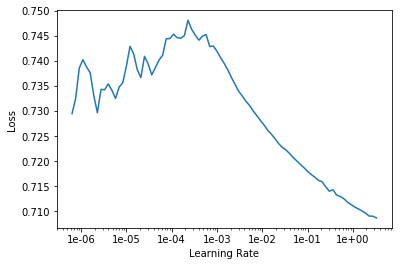

In [31]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,
1,0.425973,0.378386,0.828024
2,0.302480,0.294214,0.876835
3,0.264994,0.245941,0.897277
4,0.230096,0.230667,0.902195


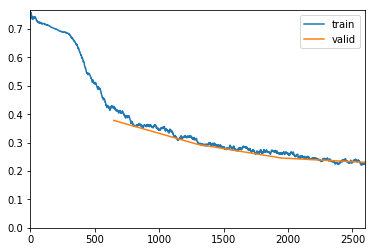

In [32]:
learn.fit_one_cycle(4 , 1e-3)

In [33]:
learn.save(f'{name}-{SZ}-stage-1')

In [34]:
#learn.load(f'{name}-{SZ}-stage-1');

In [35]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


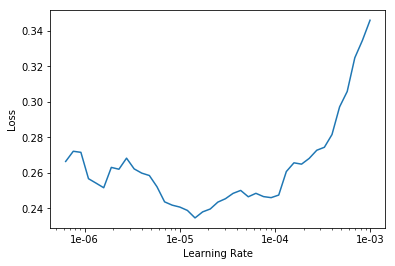

In [36]:
learn.lr_find()
learn.recorder.plot()

In [37]:
max_lr = 5e-4
lrs = slice(max_lr/90, max_lr)
learn.lr_range(lrs)

array([5.555556e-06, 5.270463e-05, 5.000000e-04])

In [38]:
learn.callback_fns.append(partial(SaveModel, every='improvement', name=f'{name}-{SZ}-stage-2'))

epoch,train_loss,valid_loss,
1,0.246278,0.226592,0.909645
2,0.248867,0.202676,0.912067
3,0.215929,0.205792,0.912838
4,0.201719,0.198756,0.904690
5,0.172881,0.149656,0.943739
6,0.150736,0.111671,0.958052
7,0.116855,0.103730,0.955153
8,0.094084,0.072252,0.969833
9,0.062177,0.042143,0.985577
10,0.044794,0.028477,0.990568


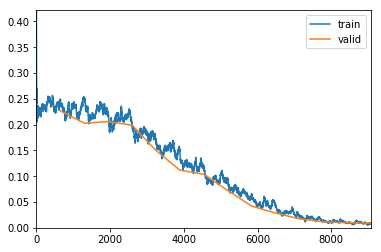

In [39]:
learn.fit_one_cycle(14, lrs, div_factor=50)

## Size 448px

In [30]:
SZ = 2*224
BS = 10
NUM_WORKERS = 8

In [31]:
classes = df.Id.unique()
data = (
    ImageItemList  ##df[(df.Id != 'new_whale') & (df.sighting_count >1)]
        .from_df( df[(df.Id != 'new_whale') & (df.sighting_count >1)], f'data/train-{SZ}', cols=['Image'])
        .no_split()##split_by_valid_func(lambda path: path2fn(path) in val_fns) 
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageItemList.from_folder(f'data/test-{SZ}'))
        .transform(get_transforms(max_lighting=0.3, max_zoom=1., do_flip=False), 
                   size=SZ, resize_method=ResizeMethod.SQUISH))

In [32]:
score = np.random.random_sample(size=(len(train),len(train)))

train_dl = DataLoader(
    TwoImDataset(data.train, score),
    batch_size=BS,
    shuffle=True,
    num_workers=NUM_WORKERS
)

end of epoch 10967
end of epoch 9758
13624 13624 13624 13624


In [33]:
data_bunch = ImageDataBunch(train_dl, train_dl) ##, valid_dl
data_bunch.add_tfm(normalize_batch)

In [34]:
learn = Learner(data_bunch, SiameseNetwork(), loss_func=BCEWithLogitsFlat(), callback_fns=[ShowGraph], 
                metrics=[lambda preds, targs: accuracy_thresh(preds.squeeze(), targs, sigmoid=False)])

In [35]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])

In [45]:
learn.load(f'{name}-224-stage-2');

In [47]:
learn.freeze_to(-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


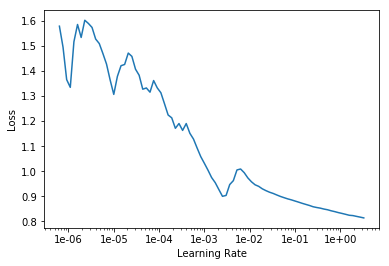

In [48]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,
1,0.198946,0.165431,0.925683
2,0.121868,0.142746,0.939408
3,0.108970,0.093887,0.961905
4,0.090538,0.084927,0.969686


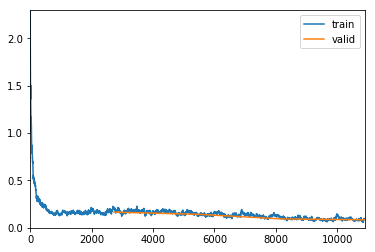

In [49]:
learn.fit_one_cycle(4 , 1e-3)

In [50]:
learn.save(f'{name}-{SZ}-stage-3')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


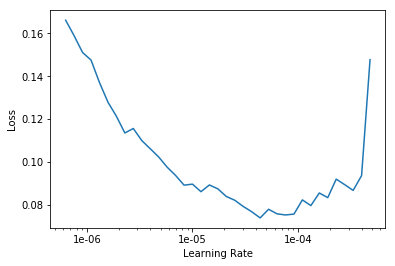

In [51]:
learn.unfreeze()

learn.lr_find()
learn.recorder.plot()

In [52]:
max_lr = 5e-4
lrs = slice(max_lr/90, max_lr)
learn.lr_range(lrs)

array([5.555556e-06, 5.270463e-05, 5.000000e-04])

In [53]:
learn.callback_fns.append(partial(SaveModel, every='epoch', name=f'{name}-{SZ}-stage-4'))

In [ ]:
#TODO! use single images as valide images

epoch,train_loss,valid_loss,
1,0.085128,0.079062,0.970713
2,0.076287,0.078720,0.972255
3,0.118275,0.078702,0.968695
4,0.107167,0.071664,0.971961
5,0.155109,0.116103,0.960474
6,0.111920,0.107798,0.961502
7,0.154586,0.093823,0.963557
8,0.114698,0.163802,0.938931
9,0.143960,0.118664,0.944326
10,0.099229,0.091944,0.963594


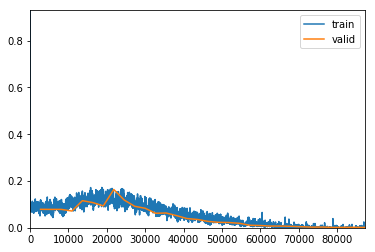

In [54]:
learn.fit_one_cycle(32, lrs, div_factor=120)

In [36]:
name, SZ

('resnet34_martin', 448)

## validate

In [36]:
learn.load(f'{name}-{SZ}-stage-4_31'); #todo add best epoch
#learn.load(f'{name}-{SZ}-stage-2');

In [37]:
new_whale_fns = set(df[df['Id']=='new_whale'].sample(frac = 1).Image.iloc[:1000])
#new_whale_fns

In [38]:
val_fns = set(df[df.sighting_count == 2].Image)
print(len(val_fns) + len(new_whale_fns))

classes = df.Id.unique()

df = df.drop(columns = ['sighting_count'])
df.head(2)

3570


,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a


In [39]:
data = (
    ImageItemList
        .from_df(df, f'data/train-{SZ}', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns) ##.union(new_whale_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageItemList.from_folder(f'data/test-{SZ}'))
        .transform(get_transforms(max_lighting=0.3, max_zoom=1., do_flip=False), 
                   size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)

In [40]:
%%time
targs = []
feats = []
learn.model.eval()
for ims, ts in data.valid_dl:
    feats.append(learn.model.process_features(learn.model.cnn(ims)).detach().cpu())  ##
    targs.append(ts)

feats = torch.cat(feats)
print(feats.shape)

torch.Size([2570, 512])
CPU times: user 9.74 s, sys: 4.95 s, total: 14.7 s
Wall time: 14.8 s


In [41]:
%%time
sims = []
for feat in feats:
    x1 = feats#.copy()
    x2 = feat.unsqueeze(0).repeat(2570 ,1)
    d1 = learn.model.calculate_distance(x1 , x2)
    d2 = (x1 + x2)
    d3 = (x1*x2)
    d4 = (x1-x2)*(x1 - x2)
    concat_layer = torch.cat([d1,d2,d3,d4], dim = 1)
    concat_layer = concat_layer.view(-1, 1, num_features_model(learn.model.cnn), 4)   
    ## no of channels is second dimension
    concat_layer  = F.relu(learn.model.conv1(concat_layer.cuda()))
    concat_layer = concat_layer.view(-1, 1, 32, num_features_model(learn.model.cnn)  )
    concat_layer = F.relu(learn.model.conv2(concat_layer))
    concat_layer_fn = concat_layer.view(-1, num_features_model(learn.model.cnn) )
    #out = learn.model.head(concat_layer_fn)
    predicted_similarity = learn.model.head(concat_layer_fn).sigmoid_()  #.cuda()
    sims.append(predicted_similarity.squeeze().detach().cpu())

CPU times: user 1min 36s, sys: 1.54 s, total: 1min 38s
Wall time: 1min 38s


In [42]:
len(sims[0])

2570

In [43]:
new_whale_idx = np.where(classes == 'new_whale')[0][0]
new_whale_idx

3

In [44]:
%%time
top_5s = []
for i, sim in enumerate(sims):
    idxs = sim.argsort(descending=True)
    probs = sim[idxs]
    top_5 = []
    for j, p in zip(idxs, probs):
        if len(top_5) == 5: break
        if j == new_whale_idx or j == i: continue
        predicted_class = data.valid_ds.y.items[j]
        if predicted_class not in top_5: top_5.append(predicted_class)
    top_5s.append(top_5)

CPU times: user 727 ms, sys: 155 µs, total: 727 ms
Wall time: 726 ms


In [45]:
top_5s[:5]

[[6, 948, 1751, 2422, 2877],
 [9, 1273, 2072, 441, 2038],
 [14, 1607, 1405, 34, 2564],
 [1573, 1535, 15, 2600, 189],
 [24, 2194, 909, 4797, 2447]]

In [46]:
"""
mapk of validation data set without having new whales in predictions. 
"""
mapk(data.valid_ds.y.items.reshape(-1,1), np.stack(top_5s), 5)

0.5766990920881971

In [47]:
%%time

for thresh in np.linspace(0.95, 1, 10):
    top_5s = []
    for i, sim in enumerate(sims):
        idxs = sim.argsort(descending=True)
        probs = sim[idxs]
        top_5 = []
        for j, p in zip(idxs, probs):
            if new_whale_idx not in top_5 and p < thresh and len(top_5) < 5: top_5.append(new_whale_idx)
            if len(top_5) == 5: break
            if j == new_whale_idx or j == i: continue
            predicted_class = data.valid_ds.y.items[j]
            if predicted_class not in top_5: top_5.append(predicted_class)
        top_5s.append(top_5)
    print(thresh, mapk(data.valid_ds.y.items.reshape(-1,1), np.stack(top_5s), 5))

0.95 0.5766990920881971
0.9555555555555555 0.5766990920881971
0.961111111111111 0.5766990920881971
0.9666666666666667 0.5766990920881971
0.9722222222222222 0.5766990920881971
0.9777777777777777 0.5766990920881971
0.9833333333333333 0.5766990920881971
0.9888888888888889 0.5766990920881971
0.9944444444444445 0.5766990920881971
1.0 0.5435278858625162
CPU times: user 8.45 s, sys: 4.06 ms, total: 8.45 s
Wall time: 8.45 s


## Predict

In [48]:
BS=8

In [49]:
data = (
    ImageItemList
        .from_df(df, f'data/train-{SZ}', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in {'69823499d.jpg'}) # in newer version of the fastai library there is .no_split that could be used here
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageItemList.from_folder(f'data/test-{SZ}'))
        .transform(None, size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)

In [50]:
!nvidia-smi

Sat Jan 19 21:11:08 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.54                 Driver Version: 396.54                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:28:00.0  On |                  N/A |
| 52%   51C    P2    49W / 210W |   2508MiB /  8116MiB |      7%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [65]:
%%time
test_feats = []
learn.model.eval()
for ims, _ in data.test_dl:
    test_feats.append(learn.model.process_features(learn.model.cnn(ims)).detach().cpu())
    
test_feats = torch.cat(test_feats)

CPU times: user 27.5 s, sys: 12.4 s, total: 39.9 s
Wall time: 40.5 s


In [69]:
%%time
train_feats = []
train_class_idxs = []
learn.model.eval()
for ims, t in data.train_dl:
    train_feats.append(learn.model.process_features(learn.model.cnn(ims)).detach().cpu())
    train_class_idxs.append(t)
    
train_class_idxs = torch.cat(train_class_idxs)
train_feats = torch.cat(train_feats)

CPU times: user 1min 28s, sys: 42.7 s, total: 2min 11s
Wall time: 2min 12s


In [70]:
len(train_class_idxs)
len(train_feats)

25360

In [71]:
del ts, t, ims, data_bunch, feats, feat, top_5s

In [72]:
del predicted_similarity, concat_layer_fn, concat_layer, x1, x2, d1, d2, d3, d4, predicted_class

In [73]:
gc.collect()

0

In [74]:
torch.cuda.empty_cache()

In [75]:
torch.cuda.memory_cached()

272760832

In [76]:
torch.cuda.memory_allocated()

256732160

In [77]:
torch.cuda.memory_cached()

272760832

In [78]:
torch.cuda.memory_allocated()

256732160

In [79]:
#torch.backends.cudnn.benchmark = True

In [82]:
!nvidia-smi

Sat Jan 19 21:18:35 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.54                 Driver Version: 396.54                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:28:00.0  On |                  N/A |
| 57%   52C    P5    22W / 210W |   1762MiB /  8116MiB |      9%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [83]:
%%time
sims = []
for feat in test_feats:
    dists = learn.model.calculate_distance(train_feats, feat.unsqueeze(0).repeat(25360, 1))
    
    x1 = train_feats
    x2 = feat.unsqueeze(0).repeat(25360, 1)
    d1 = learn.model.calculate_distance(x1, x2)
    d2 = (x1 + x2)
    d3 = (x1*x2)
    d4 = (x1-x2)*(x1-x2)
    concat_layer = torch.cat([d1, d2, d3, d4], dim = 1)
    concat_layer = concat_layer.view( - 1, 1, num_features_model(learn.model.cnn), 4)
    ## no of channels is second dimension
    #print('concat_layer shape: ' + str(concat_layer.shape))
    concat_layer  = F.relu(learn.model.conv1(concat_layer.cuda()))
    #print('concat_layer shape: ' + str(concat_layer.shape))
    concat_layer = concat_layer.view(-1, 1, 32, num_features_model(learn.model.cnn))
    #print('concat_layer shape: ' + str(concat_layer.shape))
    concat_layer = F.relu(learn.model.conv2(concat_layer))
    #print('concat_layer shape: ' + str(concat_layer.shape))
    concat_layer_fn = concat_layer.view(-1, num_features_model(learn.model.cnn))
    #print('concat_layer_fn shape: ' + str(concat_layer_fn.shape))
    predicted_similarity = learn.model.head(concat_layer_fn).sigmoid_()# .cuda()
    #print('predicted_similarity shape: ' + str(predicted_similarity.shape))
    sims.append(predicted_similarity.squeeze().detach().cpu())
    #print('sims len: ' + str(len(sims)))
    del predicted_similarity, concat_layer_fn, concat_layer, x1, x2, d1, d2, d3, d4
    gc.collect()
    torch.cuda.empty_cache()

CPU times: user 39min 49s, sys: 25min 59s, total: 1h 5min 48s
Wall time: 1h 5min 59s


In [99]:
%%time
thresh = 0.99998

top_5s = []
for sim in sims:
    idxs = sim.argsort(descending=True)
    probs = sim[idxs]
    top_5 = []
    for i, p in zip(idxs, probs):
        if new_whale_idx not in top_5 and p < thresh and len(top_5) < 5: 
            top_5.append(new_whale_idx)
        if len(top_5) == 5: break
        if i == new_whale_idx: continue
        predicted_class = train_class_idxs[i]
        if predicted_class not in top_5: top_5.append(predicted_class)
    top_5s.append(top_5)

CPU times: user 22.9 s, sys: 622 ms, total: 23.5 s
Wall time: 23.5 s


In [100]:
top_5_classes  = []

for top_5 in top_5s:
    top_5_classes.append(' '.join([classes[t] for t in top_5]))

In [101]:
top_5_classes[:5]

['w_1574bd1 new_whale w_b5c3634 w_dec7ffd w_242fb46',
 'w_4132bb8 w_8f1069a new_whale w_e3956f5 w_a4826eb',
 'new_whale w_4c218b5 w_cb50f6e w_3b15259 w_1af6b9a',
 'w_08630fd w_c99807e w_9c506f6 w_b7b1472 w_179c9f0',
 'new_whale w_dc7d6d7 w_b27b6c6 w_9ffc9aa w_c20b4e0']

In [102]:
sub = pd.DataFrame({'Image': [path.name for path in data.test_ds.x.items]})
sub['Id'] = top_5_classes
name2 = 'martin_siamese_network_res34'
sub.to_csv(f'subs/{name2}-{SZ}.csv', index=False) 

In [103]:
pd.read_csv(f'subs/{name2}-{SZ}.csv').Id.str.split().apply(lambda x: x[0] == 'new_whale').mean()

0.3701005025125628

In [187]:
#first try working port of martin piotte's siamese in fastai, thresh 1
#public score: 0.519
#mean (x[0] == 'new_whale'): 0.5541457286432161

#martin piotte's siamese in fastai, thresh 0.9
#public score: 0.505
#mean (x[0] == 'new_whale'): 0.3084170854271357

#tried to fix thresh (worked worse!)
#fixed thresh, thresh 1
#public score: 0.480
#mean (x[0] == 'new_whale'): 0.4190954773869347

#fixed thresh,  0.9999999
#public score: 0.462
#mean (x[0] == 'new_whale'): 0.2951005025125628

#using old thresh again!

#Size 448px model:

#thresh  0.99
#public score: 0.517
#mean (x[0] == 'new_whale'): 0.3079145728643216

#Size 448px resnet34, only sighting count>1

#thresh  1
#public score: 0.447
#mean (x[0] == 'new_whale'): 0.3717376458145735

#thresh  1
#public score: 0.442
#mean (x[0] == 'new_whale'): 0.3699748743718593

#thresh  0.99998
#public score: 0.442
#mean (x[0] == 'new_whale'): 0.3701005025125628


In [237]:
pd.read_csv(f'data/train.csv').Id.str.split().apply(lambda x: x[0] == 'new_whale').mean()

0.3810575292772367